In [2]:
import numpy as np
from scipy.stats import norm
from time import time
import matplotlib.pyplot as plt

## Credit risk UBSR estimation comparison between online update and SAA (Sample Average Approximation)

In [3]:
#Paramter Initialization
m = 25
n = 1000
d = 6
p = 0.05
eta = 2
lamda = 0.05
v = np.array([1 + 0.25*(i//5) for i in range(m)])
A = np.zeros((m,d+1))
A[:5,1] = A[5:10,2] = A[10:15,3] = A[15:20,4] = A[20:25,5] = A[:,6] = 0.1
A[:,0] = np.sqrt(1 - np.linalg.norm(A,axis=1)**2)
t0 = np.random.uniform(1,10,1)[0]

In [62]:

class CreditRiskUBSR:
    def __init__(self,m,d,v,A,eta,lamda,p,n,t0):
        self.m = m
        self.d = d
        self.v = np.tile(v,(n,1))
        self.A = np.tile(A,(n,1,1))
        self.eta = eta
        self.lamda = lamda
        self.p = p
        self.n = n
        self.Z = self.sample_Z()
        self.eps = self.sample_eps()
        self.R = self.calc_R()
        self.D = self.calc_D()
        self.xi = self.calc_xi()
        self.c = 100
        self.tl = 1
        self.tu = 10
        self.tk = np.random.uniform(self.tl,self.tu,1)[0]
        
    def sample_Z(self):
        Z = np.random.normal(0,1,(self.n,self.d))
        return np.tile(Z,(self.m,1,1))
    
    def sample_eps(self):
        eps = np.random.normal(0,1,(self.n,self.m))
        return eps
    
    def calc_R(self):
        R = np.zeros((self.n,self.m))
        R = self.eps*self.A[:,:,0] 
        for j in range(1,7):
            R += self.A[:,:,j]*self.Z[:,:,j-1].T
        return R
    
    def calc_D(self):
        r = norm.ppf(1-self.p)*np.ones((self.n,self.m))
        D = (self.R>r).astype(int)
        return D
    
    def calc_xi(self):
        xi = np.sum(self.v*self.D,axis=1)
        return xi
    
    def l(self,x):
        return 1/self.eta*(x>0).astype(int)*x**self.eta
    
    def ln_t(self,t):
        return np.sum(self.l(self.xi-t)) / self.n
    
    def ln_t_(self,t,k):
        return np.sum(self.l(self.xi[:k]-t)) / k
    
    def update_t(self,k):
        ak = self.c/k
        g_hat = self.l(self.xi[k-1]-self.tk) - self.lamda
        self.tk = self.tk + ak*g_hat
        self.tk = min(max(self.tk,self.tl),self.tu)
        
        
    def online_estimator(self):
        self.online_times = []
        self.online_ts = []
        start = time()
        for k in range(1,self.n+1):
            self.update_t(k)
            if k%10==0:
                self.online_times.append(time()-start)
                self.online_ts.append(self.tk)
            
    def SAA_estimator(self):
        self.SAA_tstars = []
        self.SAA_times = []
        start = time()
        for k in np.arange(10,self.n+1,10):
            error = 500
            tl = self.tl
            tu = self.tu
            x = 0
            while abs(error)>1e-3:
                ti = (tl+tu)/2
                error = self.lamda - self.ln_t_(ti,k)
                if error<0:
                    tl = ti
                else:
                    tu = ti
                x+=1
                if x==10000:
                    break
            self.SAA_tstars.append(ti)
            self.SAA_times.append(time()-start)
            
    def estimate_tstar(self):
        tl = self.tl
        tu = self.tu
        error = 100
        x = 0
        while abs(error)>1e-3:
            ti = (tl+tu)/2
            error = self.lamda - self.ln_t(ti)
            if error<0:
                tl = ti
            else:
                tu = ti
            x += 1
            if x==10000:
                break
        return round(ti,4)

In [63]:
online_ts = []
online_times = []
SAA_tstars = []
SAA_times = []
from tqdm.notebook import tqdm
for i in tqdm(range(1000)):
    ubsr = CreditRiskUBSR(m,d,v,A,eta,lamda,0.05,10000,t0)
    ubsr.online_estimator()
    ubsr.SAA_estimator()
    online_ts.append(ubsr.online_ts)
    online_times.append(ubsr.online_times)
    SAA_tstars.append(ubsr.SAA_tstars)
    SAA_times.append(ubsr.SAA_times)

  0%|          | 0/1000 [00:00<?, ?it/s]

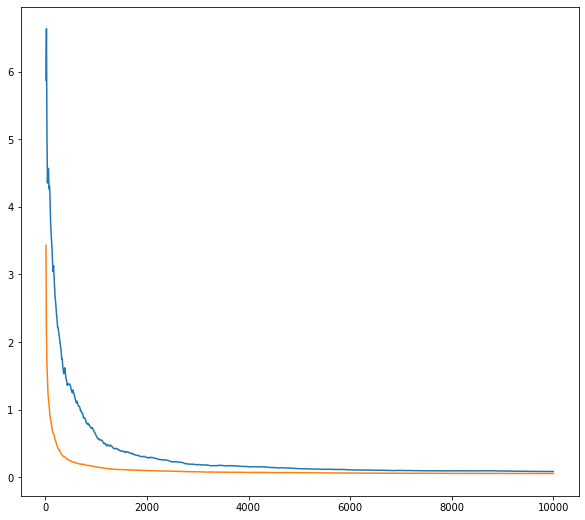

In [65]:
sr = 5.11
plt.figure(figsize=(10,9))
plt.plot(list(range(10,ubsr.n+1,10)),np.mean((np.array(online_ts) - sr)**2,axis=0))
plt.plot(np.arange(10,ubsr.n+1,10),np.mean((np.array(SAA_tstars) - sr)**2,axis=0))

In [67]:
rows = []
rows.append([100,np.mean((np.array(online_ts) - sr)**2,axis=0)[9],
             np.mean((np.array(SAA_tstars) - sr)**2,axis=0)[9],
             np.sum(np.array(online_times),axis=0)[9],np.sum(np.array(SAA_times),axis=0)[9]])
rows.append([1000,np.mean((np.array(online_ts) - sr)**2,axis=0)[99],
             np.mean((np.array(SAA_tstars) - sr)**2,axis=0)[99],
             np.sum(np.array(online_times),axis=0)[99],np.sum(np.array(SAA_times),axis=0)[99]])
rows.append([10000,np.mean((np.array(online_ts) - sr)**2,axis=0)[999],
             np.mean((np.array(SAA_tstars) - sr)**2,axis=0)[999],
             np.sum(np.array(online_times),axis=0)[999],np.sum(np.array(SAA_times),axis=0)[999]])

In [54]:
import pandas as pd

In [68]:
df = pd.DataFrame(data=rows,columns=['samples','Online estimation error','SAA error','Online estimation time taken','SAA time taken'])

In [71]:
df.round(4).to_csv('time comparison.csv',index=False)

In [75]:
df_plot = pd.DataFrame()
df_plot['Samples'] = np.arange(10,ubsr.n+1,10)
df_plot['SAA error mean'] = np.mean((np.array(SAA_tstars) - sr)**2,axis=0)
df_plot['Online error mean'] = np.mean((np.array(online_ts) - sr)**2,axis=0)
df_plot['SAA error std'] = np.std((np.array(SAA_tstars) - sr)**2,axis=0)
df_plot['Online error std'] = np.std((np.array(online_ts) - sr)**2,axis=0)

In [76]:
df_plot.to_csv('plot_data.csv',index=False)

In [9]:
import pandas as pd
df = pd.read_csv('time comparison.csv')

In [10]:
df

,samples,Online estimation error,SAA error,Online estimation time taken,SAA time taken
0,100,3.8175,0.8488,0.3762,1.8109
1,1000,0.6142,0.1517,3.0875,9.1270
2,10000,0.0838,0.0539,30.5046,145.4006


In [3]:
df = pd.read_csv('plot_data.csv')

In [5]:
import numpy as np

In [6]:
df['SAA error std'] /= np.sqrt(1000)
df['Online error std'] /= np.sqrt(1000)

In [7]:
df.to_csv('plot_data.csv',index=False)